<a href="https://colab.research.google.com/github/poojagpta/releases/blob/master/m5_forecasting_project/walmart_naive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
pd.pandas.set_option("display.max_columns",None)
sns.set()
from tqdm.notebook import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cal_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/calendar.csv")
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/sales_train_validation.csv")
price_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/sell_prices.csv")

In [3]:
price_df['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

**The M5 dataset**, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI)

**Calculating the weight of the bottom series**
Weight of each series will be computed based on the last 28 observations of the training sample of the dataset, i.e., the cumulative actual dollar sales that each series displayed in that particular period (sum of units sold multiplied by their respective price)


In [4]:
price_df['id'] = price_df['item_id']+'_'+price_df['store_id']+'_validation'
cal_df['d'] = cal_df['d'].apply(lambda x: int(x.split("_")[1]))

In [5]:
for day in tqdm(range(1858,1886)):
    wk_id=list(cal_df[cal_df['d']==day]['wm_yr_wk'])[0]
    wk_price_df = price_df[price_df['wm_yr_wk'] == wk_id]
    df =df.merge(wk_price_df[["id","sell_price"]], on="id",how="inner")
    df['unit_sale_'+ str(day)] = df["sell_price"] * df['d_'+str(day)]
    df.drop(columns=["sell_price"], inplace=True)

  0%|          | 0/28 [00:00<?, ?it/s]

In [6]:
df['dollar_sales'] = df[[c for c in df.columns if c.find("unit_sale")==0]].sum(axis=1)

In [7]:
df['weight'] = df['dollar_sales']/df['dollar_sales'].sum()

In [8]:
df['weight'].sum()

0.9999999999999999

In [9]:
df.drop(columns=["dollar_sales"], axis=1, inplace=True)

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/dataset.csv',sep=',')

#Naive Forecast for all 12 series listed
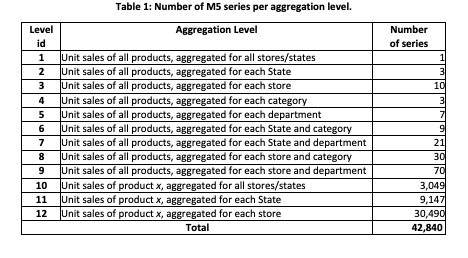


**Using bottom up approach**
- Average through all history
- Same as previous 28 days
- Mean of previous 10,20,40 days

In [10]:
method_dict ={1: 'complete historical mean', \
              2: 'historical mean after first non zero sales', \
              3: 'Same as previous 28 days', \
              4: 'Mean of previous 10 days', \
              5: 'Mean of previous 20 days', \
              6: 'Mean of previous 40 days'
             }

Complete Historical Mean

In [11]:
complete_historical_mean_df =\
    df[[c for c in df.columns if c.find("d_")==0 and int(c.split("_")[1]) <= 1885] +\
       ["id"]].set_index("id").transpose().mean().reset_index()

In [12]:
complete_historical_mean_df


,id,0
0,HOBBIES_1_001_CA_1_validation,0.303979
1,HOBBIES_1_002_CA_1_validation,0.260477
2,HOBBIES_1_003_CA_1_validation,0.144297
3,HOBBIES_1_004_CA_1_validation,1.717241
4,HOBBIES_1_005_CA_1_validation,0.960743
...,...,...
30485,FOODS_3_823_WI_3_validation,0.538992
30486,FOODS_3_824_WI_3_validation,0.377188
30487,FOODS_3_825_WI_3_validation,0.894960
30488,FOODS_3_826_WI_3_validation,0.358621


In [13]:
for d in range(1,29):
    df['F_1_'+ str(1885+d)] = list(complete_historical_mean_df[0])

In [14]:
df['F_1_1886']

0        0.303979
1        0.260477
2        0.144297
3        1.717241
4        0.960743
           ...   
30485    0.538992
30486    0.377188
30487    0.894960
30488    0.358621
30489    0.689125
Name: F_1_1886, Length: 30490, dtype: float64

Historical mean after first non zero sales

In [15]:
def find_first_non_0(s):
    assert type(s) == np.ndarray
    return (s!=0).argmax(axis=0)

In [16]:
non_0_strt_arr = []
hist_arr = np.array(df[[c for c in df.columns if c.find("d_")==0]])
for i in tqdm(range(len(df))):
    non_0_strt_arr.append(find_first_non_0(hist_arr[i, :]))

  0%|          | 0/30490 [00:00<?, ?it/s]

In [17]:
num_non_zero_start = 1885 - np.array(non_0_strt_arr)

In [18]:
historical_mean_arr = df[[c for c in df.columns if c.find('d_')==0 and int(c.split('_')[1]) <=1885] + ['id']].set_index('id')\
.sum(axis=1).reset_index()[0]/num_non_zero_start

In [ ]:
historical_mean_arr

0        0.582317
1        0.281860
2        0.348718
3        1.750676
4        1.021433
           ...   
30485    0.539565
30486    0.378191
30487    0.895435
30488    0.714588
30489    1.720530
Name: 0, Length: 30490, dtype: float64

In [19]:
for d in range(1,29):
    df['F_2_'+ str(1885+d)] = historical_mean_arr

Same as previous 28 days

In [20]:
for d in range(1,29):
    df['F_3_'+ str(1885+d)] = df['d_'+str(1885+d- 28)]

Mean from recent X days

In [23]:
num_non_zero_start.min()

40

The minimum non zero start days are 40, therefore mean of 10,20,40 should all have non-zero start. 

In [21]:
historical_mean_df10 = df[[c for c in df.columns if c.find('d_')==0 and int(c.split('_')[1]) in range(1876,1886)]+['id']] \
 .set_index('id')\
 .mean(axis=1).reset_index()

historical_mean_df20 = df[[c for c in df.columns if c.find('d_')==0 and int(c.split('_')[1]) in range(1866,1886)]+['id']] \
 .set_index('id')\
 .mean(axis=1).reset_index()

historical_mean_df40 = df[[c for c in df.columns if c.find('d_')==0 and int(c.split('_')[1]) in range(1846,1886)]+['id']] \
 .set_index('id')\
 .mean(axis=1).reset_index()

In [22]:
for d in range(1,29):
    df['F_4_'+ str(1885+d)] = list(historical_mean_df10[0])
    df['F_5_'+ str(1885+d)] = list(historical_mean_df20[0])
    df['F_6_'+ str(1885+d)] = list(historical_mean_df40[0])

Infer forecast , validation/ground truth value

In [ ]:
agg_df = pd.DataFrame(df[[c for c in df.columns if c.find("d_")==0 or c.find("F_")==0]].sum()).transpose()
agg_df['level']=1
agg_df['weight']=1/12
column_order = agg_df.columns

In [ ]:
level_groupings = {2:["state_id"], 3:["store_id"], 4:["cat_id"], 5:["dept_id"],
                  6:["state_id","cat_id"],7:["state_id","dept_id"],
                  8:["store_id","cat_id"], 9:["store_id","dept_id"],
                  10:["item_id"], 11:["item_id","state_id"]}

Note: Here weight calculated above is divided by 12 (As we are predicted for 12 heirarchical dataset

In [ ]:
for level in tqdm(level_groupings):
    temp_df = df.groupby(by=level_groupings[level]).sum().reset_index(drop=True)
    temp_df['level'] = level
    temp_df['weight']/=12
    agg_df = agg_df.append(temp_df[column_order])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
df['weight']/=12 

In [ ]:
print(df.shape[0], agg_df.shape[0], df.shape[0] + agg_df.shape[0])

30490 12350 42840


In [ ]:
agg_df['weight'].sum()+df['weight'].sum()

0.9999999999999996

**Accuracy function provide by Walmart**

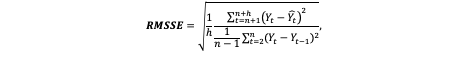

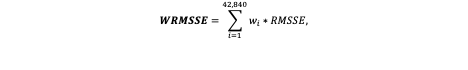

In [ ]:
h = 28
n = 1885
def rmsse(ground_truth, forecast, train_series, axis=1):
    # assuming input are numpy array or matrices
    assert axis == 0 or axis == 1
    assert type(ground_truth) == np.ndarray and type(forecast) == np.ndarray and type(train_series) == np.ndarray
    
    if axis == 1:
        # using axis == 1 we must guarantee these are matrices and not arrays
        assert ground_truth.shape[1] > 1 and forecast.shape[1] > 1 and train_series.shape[1] > 1
    
    numerator = ((ground_truth - forecast)**2).sum(axis=axis)
    if axis == 1:
        denominator = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=axis)
    else:
        denominator = 1/(n-1) * ((train_series[1:] - train_series[:-1]) ** 2).sum(axis=axis)
    return (1/h * numerator/denominator) ** 0.5

Split into training and validation data set
Here, we are forecast for 28 days of data
- Training Series : 0 - 1885
- Validation/Ground truth : 1886 - 1913

In [ ]:
train_series_cols = [c for c in df.columns if c.find("d_") == 0][:-28]
ground_truth_cols = [c for c in df.columns if c.find("d_") == 0][-28:]

forecast_cols_dict={}

for i in range(1,7):
    forecast_cols_dict[i] = [c for c in df.columns if c.find('F_'+str(i)+"_") == 0]

In [ ]:
for i in range(1,7):
    agg_df["rmsse_"+str(i)+'_bu'] = rmsse(np.array(agg_df[ground_truth_cols]), \
                   np.array(agg_df[forecast_cols_dict[i]]), np.array(agg_df[train_series_cols]))
    df["rmsse_"+ str(i)+'_bu'] = rmsse(np.array(df[ground_truth_cols]), \
                          np.array(df[forecast_cols_dict[i]]), np.array(df[train_series_cols]))

In [ ]:
for i in range(1,7):
    df['wrmsse_'+str(i)+'_bu'] = df['weight']*df["rmsse_"+ str(i)+'_bu']
    agg_df['wrmsse_'+str(i)+'_bu'] = agg_df['weight']* agg_df['rmsse_'+str(i)+'_bu']

In [ ]:
for i in range(1,7):
    print('method:'+method_dict[i])
    print(df['wrmsse_'+str(i)+'_bu'].sum()+agg_df['wrmsse_'+str(i)+'_bu'].sum())

method:complete historical mean
1.654145319495266
method:historical mean after first non zero sales
1.2467448505459666
method:Same as previous 28 days
0.8558233199674036
method:Mean of previous 10 days
1.1682107851100296
method:Mean of previous 20 days
1.1412136208411776
method:Mean of previous 40 days
1.1380883217322864


As per result above, the best model is when we took previous 28 days model for forecasting the future.

**Top Down Approach**

In [53]:
agg_df_tp = pd.DataFrame(df[[c for c in df.columns if c.find("d_") == 0]].sum()).transpose()
id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
for col in id_cols:
    agg_df_tp[col] = 'all'
agg_df_tp["level"] = 1
agg_df_tp["weight"] = 1/12
column_order = agg_df_tp.columns

In [54]:
for level in tqdm(level_groupings):
    temp_df = df.groupby(by=level_groupings[level]).sum().reset_index()
    temp_df["level"] = level
    for c in column_order:
        if c not in temp_df.columns:
            temp_df[c] = 'all'
    agg_df_tp = agg_df_tp.append(temp_df[column_order])

del temp_df

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
agg_df_tp.to_csv('/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/top_down_agg_levels.csv',sep=',')

In [55]:
print(df.shape[0], agg_df_tp.shape[0], df.shape[0] + agg_df_tp.shape[0])

30490 12350 42840


In [56]:
agg_df_tp["weight"].sum() + df["weight"].sum()

11.083333333333329

Estimate model at walmart level and then redistribute forecast to all hierarchy using historical 28 days propositions.

In [57]:
df["last28_mean"] = df[[c for c in df.columns if c.find("d_")==0 and\
        int(c.split("_")[1]) in range(1858, 1886)] +\
       ["id"]].set_index("id").transpose().mean().reset_index()[0]

In [63]:
for l in tqdm(range(1, 10)):
    # 1. make forecast for this level
    this_level_df = agg_df_tp[agg_df_tp["level"]==l].copy()
    for d in range(1, 29):
        this_level_df["F_" + str(l) + "_" + str(1885 + d)] = this_level_df["d_" + str(1885 + d - 28)]
    
    # from this level, distribute forecast to all level 12 series
    # find columns with non 'all' entries
    important_column_ids = list(this_level_df[id_cols].columns[this_level_df[id_cols].nunique()!=1])
    this_level_df.reset_index(drop=True, inplace=True)
    for i, row in this_level_df.iterrows():
        #eg. level =1
        if len(important_column_ids) == 0:
            level_mean_with_cond = this_level_df[[c for c in df.columns if c.find("d_")==0 and\
                                   int(c.split("_")[1]) in range(1858, 1886)]].transpose().mean()[0]
            proportion = df["last28_mean"] / level_mean_with_cond 
            for d in range(1, 29):
                df["F_" + str(l) + "_" + str(1885 + d)] = list(this_level_df["F_" + str(l) + "_" + str(1885 + d)])[0] * proportion
        else:
           #eg. Level 2 and above
            cond = True
            for col in important_column_ids:
                cond = cond & (df[col] == row[col])
                
            level_mean_with_cond = this_level_df[[c for c in df.columns if c.find("d_")==0 and\
                                   int(c.split("_")[1]) in range(1858, 1886)]].transpose().mean()[i]
            proportion = df["last28_mean"] / level_mean_with_cond 
            for d in range(1, 29):
                df.loc[cond, "F_" + str(l) + "_" + str(1885 + d)] = row["F_" + str(l) + "_" + str(1885 + d)] * proportion
    
# remake agg_df
new_agg_df = pd.DataFrame(df[[c for c in df.columns if c.find("d_") == 0 or c.find("F_") == 0]].sum()).transpose()
id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
for col in id_cols:
    new_agg_df[col] = 'all'
new_agg_df["level"] = 1
new_agg_df["weight"] = 1/12
column_order = new_agg_df.columns

for level in level_groupings:
    temp_df = df.groupby(by=level_groupings[level]).sum().reset_index()
    temp_df["level"] = level
    for c in column_order:
        if c not in temp_df.columns:
            temp_df[c] = 'all'
    new_agg_df = new_agg_df.append(temp_df[column_order])
del temp_df

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
train_series_cols = [c for c in df.columns if c.find("d_") == 0][:-28]
ground_truth_cols = [c for c in df.columns if c.find("d_") == 0][-28:]

forecast_cols_dict = {}
for i in range(1, 10):
    forecast_cols_dict[i] = [c for c in df.columns if c.find("F_"+str(i)+"_") == 0]

In [ ]:
for i in range(1, 10):
    df["rmsse_" + str(i)+'_tp'] = rmsse(np.array(df[ground_truth_cols]), 
        np.array(df[forecast_cols_dict[i]]), np.array(df[train_series_cols]))
    new_agg_df["rmsse_" + str(i)+'_tp'] = rmsse(np.array(new_agg_df[ground_truth_cols]), 
        np.array(new_agg_df[forecast_cols_dict[i]]), np.array(new_agg_df[train_series_cols]))

In [ ]:
for i in range(1, 10):
    df["wrmsse_" + str(i)+'_tp'] = df["weight"] * df["rmsse_" + str(i)+'_tp']
    new_agg_df["wrmsse_" + str(i)+'_tp'] = new_agg_df["weight"] * new_agg_df["rmsse_" + str(i)+'_tp']

In [ ]:
for i in range(1, 10):
    print("Aggregation by level", str(i) + ":")
    print(df["wrmsse_" + str(i)+'_tp'].sum() + new_agg_df["wrmsse_" + str(i)+'_tp'].sum())
    print()

Aggregation by level 1:
0.7526969415454267

Aggregation by level 2:
0.7583278269835318

Aggregation by level 3:
0.7640636603286007

Aggregation by level 4:
0.7573295317439532

Aggregation by level 5:
0.75430855086912

Aggregation by level 6:
0.7635048362696782

Aggregation by level 7:
0.7618576696686441

Aggregation by level 8:
0.7717987726658355

Aggregation by level 9:
0.7726889521635331



In top down approach aggregation at the top level is better than other level.

Average of MAPE Validation for Level 1 

In [87]:
mape_df = new_agg_df[new_agg_df['level']==1].copy()
total_mape = 0.0
total_count = 0
for d in range(1,29):
       total_mape += 1 - np.divide(np.absolute(np.subtract(mape_df['F_1_'+str(1885+d)], mape_df['d_'+str(1885+d)])),  mape_df['d_'+str(1885+d)])
       total_count=total_count+1
print('Average of MAPE for 28 days prediction : '+ str((total_mape[0]/total_count)*100))             

Average of MAPE for 28 days prediction : 94.08700567258444
